## Predicting whether a tissue sample is a tumor or normal from miRNA expression data using bagging support vector machines
#The code is forked and only slighlty modified from https://www.kaggle.com/thomasnelson/predicting-if-sample-is-tumor-bagsvm, I just tried to fit it more to what I encounter in day-to-day work. All credits to the original poster

### Import modules and the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
data = pd.read_csv("cervical.csv")

### Take a look at the top of the data, we have 714 features and 58 samples, plus a column of miRNA names.

In [21]:
print(data.shape)
data.head()

(714, 59)


,ID,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
0,let-7a,865,810,5505,6692,1456,588,9,4513,1962,...,37,3174,116,1722,68,12121,14398,39196,198,1422
1,let-7a*,3,12,30,73,6,2,0,199,10,...,0,648,4,212,6,2,80,164,18,1
2,let-7b,975,2790,4912,24286,1759,508,33,6162,1455,...,99,102358,184,28274,401,14471,24097,73139,669,2492
3,let-7b*,15,18,27,119,11,3,0,116,17,...,0,334,1,189,5,34,115,230,4,15
4,let-7c,828,1251,2973,6413,713,339,23,2002,476,...,34,1711,22,3127,199,3186,1454,5883,167,321


### Let's look at the library sizes (total read counts per sample)

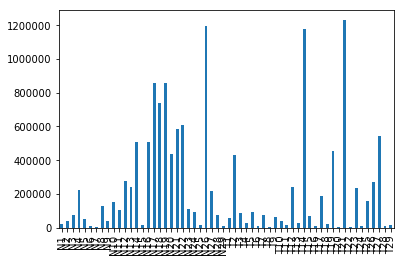

In [4]:
sizes = data.sum(numeric_only=True)
sizes.plot.bar()

### Normalization

Our library sizes are very different.  Standard practice is to use some normalization method.

Here I use the normalization method of counts per milion (CPM).  We divide each count by the library size to give the proportion of total reads for each gene, then multiply by 1 million to get counts per 1 million.

In [22]:
#Alternative: I keep the ID col in a separated variable, drop it, do the cpm and then insert it back (no needed for actual calculations)
ID = data.ID 
data = data.drop('ID', 1) # 1 is the axis (column)
sums = data.sum()
cpm = (data.div(sums))*1000000
cpm.insert(loc=0, column='ID', value=ID)

In [23]:
print(cpm.shape)
cpm.head()

(714, 59)


,ID,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29
0,let-7a,38531.783153,20352.781547,76760.042947,30209.461900,27533.518655,64283.371597,6807.866868,36119.603669,52587.847436,...,11923.944570,2586.676903,33001.422475,7373.595506,8835.758836,76912.338589,52987.005340,72541.794445,29320.302088,87036.356959
1,let-7a*,133.636242,301.522690,418.310861,329.541351,113.462302,218.650924,0.000000,1592.688041,268.031842,...,0.000000,528.092827,1137.980085,907.782954,779.625780,12.690758,294.413143,303.522152,2665.482008,61.207002
2,let-7b,43431.778698,70104.025328,68491.431599,109633.441676,33263.364914,55537.334645,24962.178517,49317.305076,38998.633038,...,31904.608443,83417.477754,52347.083926,121069.128528,52104.989605,91823.979187,88680.918716,135361.626286,99067.081297,152527.849186
3,let-7b*,668.181211,452.284034,376.479775,537.197544,208.014221,327.976386,0.000000,928.401069,455.654132,...,0.000000,272.195994,284.495021,809.297068,649.688150,215.742885,423.218892,425.671311,592.329335,918.105031
4,let-7c,36883.602833,31433.740389,41454.606300,28949.981943,13483.103572,37061.331584,17397.881997,16022.921902,12758.315688,...,10957.138253,1394.393251,6258.890469,13389.798575,25857.588358,20216.377423,5350.958867,10887.931848,24729.749741,19647.447668


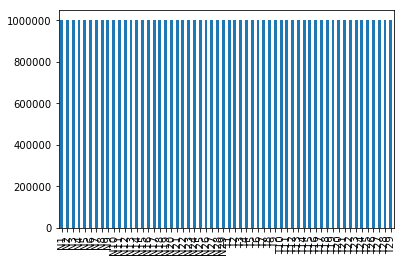

In [24]:
sizes = cpm.sum(numeric_only=True)
sizes.plot.bar()

### Here I re-format the data into a form suitable for input into the machine learning algorithm (put smples as rows and features as columns and create a vector of class labels for scikit-learn)

In [25]:
cpm = cpm.transpose()
cpm = np.array(cpm[1:])
class_labels = np.array(["normal"]*29 + ["tumor"]*29)

In [26]:
cpm

array([[38531.78315292441, 133.63624214887076, 43431.778698383, ..., 0.0,
        0.0, 44.54541404962359],
       [20352.7815468114, 301.5226895823911, 70104.02532790593, ...,
        25.12689079853259, 50.25378159706518, 0.0],
       [76760.0429465817, 418.3108607443144, 68491.43159920242, ..., 0.0,
        0.0, 27.88739071628763],
       ..., 
       [72541.79444517446, 303.5221524902697, 135361.626286499, ...,
        7.402979329030968, 12.955213825804195, 12.955213825804195],
       [29320.302087960907, 2665.482007996446, 99067.08129720124, ..., 0.0,
        0.0, 0.0],
       [87036.35695923613, 61.20700208103807, 152527.84918594686, ..., 0.0,
        0.0, 0.0]], dtype=object)

In [27]:
class_labels

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'tumor', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor'], 
      dtype='<U6')

### Now we need to scale the data, that prevents the really highly expressed miRNA's from overwhelming influence on the model.  We get a warning about converting data type but thats okay.

In [28]:
from sklearn.preprocessing import StandardScaler

sc_cpm = StandardScaler()
cpm = sc_cpm.fit_transform(cpm)

/Users/marcop/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [29]:
cpm

array([[ 0.16375984, -0.71724117, -0.8802064 , ..., -0.28985132,
        -0.48013976,  0.7757562 ],
       [-0.53465168, -0.48861301, -0.09556051, ...,  0.81048475,
         4.80271218, -0.25745491],
       [ 1.63243551, -0.3295706 , -0.1429999 , ..., -0.28985132,
        -0.48013976,  0.38938074],
       ..., 
       [ 1.47037637, -0.48589014,  1.82419185, ...,  0.03433384,
         0.88175728,  0.04303552],
       [-0.19013223,  2.73063234,  0.75647656, ..., -0.28985132,
        -0.48013976, -0.25745491],
       [ 2.02723696, -0.81587548,  2.32918892, ..., -0.28985132,
        -0.48013976, -0.25745491]])

### Now we'll use support vector machines with a linear kernel to create a classifier.  Here I use bagging (bootstrap aggregating), an ensemble method, to avoid overfitting a small data set. 

In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
svc = svm.SVC(kernel='linear', C=1.0)

#Set a RANDOM_STATE to use for Bagging and cross validation
RANDOM_STATE=123454321

classifier = BaggingClassifier(base_estimator = svc, n_estimators = 10, random_state=RANDOM_STATE)


**10-fold Cross-validation by explicitly calling the StratifiedKFold method to control the random_state param.**

In [31]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv=StratifiedKFold(n_splits=10, random_state=RANDOM_STATE)
scores = cross_val_score(classifier, cpm, class_labels, cv=cv)

The score is the mean of all scores in the array.

In [32]:
print("10-Cross validated Prediction Accuracy: {}%".format(scores.mean()*100))

10-Cross validated Prediction Accuracy: 91.66666666666667%
